In [1]:
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,
                         env_map,
                         init_pose,
                         num,
                         motion_noise_stds={'nn': 0.19, 'no': 0.001, 'on': 0.13, 'oo': 0.2},
                         distance_dev_rate=0.14,
                         direction_dev=0.05,
                         amcl_params={'slow': 0.001, 'fast': 0.1, 'nu': 3.0}):
        super().__init__(env_map, init_pose, num, motion_noise_stds, distance_dev_rate, direction_dev)
        self.amcl_params = amcl_params
        self.slow_term_alpha = 1.0
        self.fast_term_alpha = 1.0
        
    def sensor_resetting_draw(self, particle, landmark_pos, ell_obs, phi_obs):
        psi = np.random.uniform(-math.pi, math.pi)
        ell = norm(loc=ell_obs, scale=(ell_obs * self.distance_dev_rate) * 2).rvs()
        particle.pose[0] = landmark_pos[0] + ell * math.cos(psi)
        particle.pose[1] = landmark_pos[1] + ell * math.sin(psi)
        
        phi = norm(loc=phi_obs, scale=self.direction_dev ** 2).rvs()
        particle.pose[2] = math.atan2(landmark_pos[1] - particle.pose[1], landmark_pos[0] - particle.pose[0]) - phi
        
        particle.weight = 1.0 / len(self.particles)
        
    def adaptive_resetting(self, observation):
        if len(observation) == 0:
            return
        
        alpha = sum([p.weight for p in self.particles])
        self.slow_term_alpha += self.amcl_params['slow'] * (alpha - self.slow_term_alpha)
        self.fast_term_alpha += self.amcl_params['fast'] * (alpha - self.fast_term_alpha)
        sl_num = len(self.particles) * max([0, 1.0 - self.amcl_params['nu'] * self.fast_term_alpha / self.slow_term_alpha])
        
        self.resampling()
        
        nearest_obs = np.argmin([obs[0][0] for obs in observation])
        values, landmark_id = observation[nearest_obs]
        
        for _ in range(int(sl_num)):
            p = random.choices(self.particles)[0]
            self.sensor_resetting_draw(p, self.env_map.landmarks[landmark_id].pos, *values)
    
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.env_map, self.distance_dev_rate, self.direction_dev)
        
        self.set_ml()
        
        self.adaptive_resetting(observation)

<IPython.core.display.Javascript object>


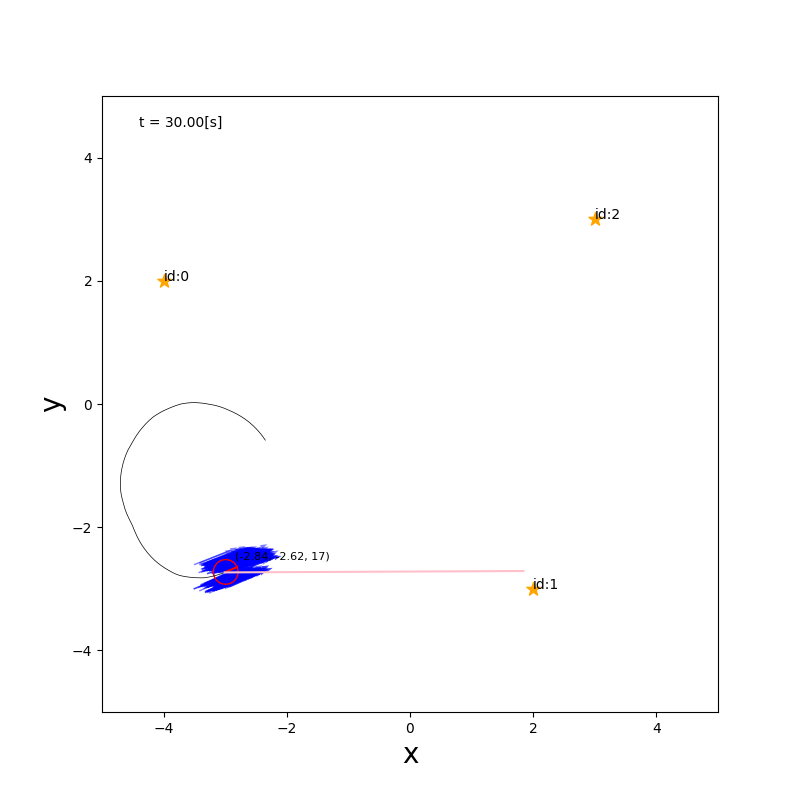

In [4]:
def trial():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    m = Map()
    for lm in [(-4, 2), (2, -3), (3, 3)]:
        m.append_landmark(Landmark(*lm))
    world.append(m)
    
    init_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    robot_pose = np.array([np.random.uniform(-5.0, 5.0), np.random.uniform(-5.0, 5.0), np.random.uniform(-math.pi, math.pi)]).T
    pf = ResetMcl(m, init_pose, 1000)
    a = EstimationAgent(time_interval, 0.2, 10.0 / 180 * math.pi, pf)
    r = Robot(robot_pose, sensor=Camera(m), agent=a, color='red')
    world.append(r)
    
    world.draw()
    
trial()